In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LayerNormalization, Bidirectional, LSTM, GRU, Layer, GlobalAveragePooling1D, Activation
from tensorflow.keras.layers import Lambda, Reshape, Flatten, Input, MultiHeadAttention, Flatten, Concatenate, Add, Multiply, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random
import torch

2025-12-15 19:10:01.324713: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
def clean_and_interpolate(data):
    df = pd.DataFrame(data).astype(np.float32)
    
    df_linear = df.interpolate(method='linear', limit_direction='both', axis=1, limit=None)
    df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

    df_final = df_spline.fillna(0)
    
    # Clip extreme values
    df_interpolated_fin = df_final.clip(-1e6, 1e6)
    print(f"Final NaN count: {df_interpolated_fin.isnull().sum().sum()}")
    result = df_interpolated_fin.values
    
    return result

In [4]:
# Slope + elevation - fixed constraint

def multi_focal_loss_slope_elevation_constraint(slope_values, elevation_values,
                                                slope_threshold=40, elevation_threshold=2000,
                                                alpha=0.25, gamma=2.0,
                                                lambda_slope=0.4, lambda_elevation=0.3):
    def loss(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred_clipped = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        ce = -y_true * tf.math.log(y_pred_clipped)
        p_t = tf.where(tf.equal(y_true, 1), y_pred_clipped, 1 - y_pred_clipped)
        
        # Alpha weighting for class imbalance
        alpha_t = tf.where(tf.equal(y_true[:, 1], 1), alpha, 1 - alpha)
        
        # Focal loss calculation
        focal_weight = tf.expand_dims(alpha_t, 1) * tf.pow((1 - p_t), gamma)
        focal_loss = focal_weight * ce
        focal_loss = tf.reduce_mean(tf.reduce_sum(focal_loss, axis=1))
        
        # Get batch data
        batch_size = tf.shape(y_pred)[0]
        slope_batch = tf.gather(slope_values, tf.range(batch_size))
        elevation_batch = tf.gather(elevation_values, tf.range(batch_size))
        
        # ISA predictions
        isa_pred = y_pred[:, 0]
        
        # CONSTRAINT 1: Slope constraint
        slope_mask = tf.cast(slope_batch > slope_threshold, tf.float32)
        slope_penalty = tf.reduce_mean(tf.multiply(slope_mask, isa_pred))
        
        # CONSTRAINT 2: Elevation constraint
        elevation_mask = tf.cast(elevation_batch > elevation_threshold, tf.float32)
        elevation_penalty = tf.reduce_mean(tf.multiply(elevation_mask, isa_pred))
        
        # Combine all losses
        total_loss = focal_loss + (lambda_slope * slope_penalty) + (lambda_elevation * elevation_penalty)
        
        return total_loss
    
    return loss

In [5]:
def prepare_multi_region_data(ph_paths, kor_paths, cbr_paths):
    def load_region_data(paths):
        # Load all dataframes for a region
        ndvi_df = pd.read_csv(paths['ndvi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        mndwi_df = pd.read_csv(paths['mndwi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        ndbi_df = pd.read_csv(paths['ndbi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        ndbsi_df = pd.read_csv(paths['ndbsi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        cbi_df = pd.read_csv(paths['cbi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        uci_df = pd.read_csv(paths['uci'],delimiter=';', encoding='utf-8-sig',decimal=',')
        print('NDVI shape before int:', ndvi_df.shape)
        
        # Extract features
        ndvi_features = ndvi_df.iloc[:,5:29].values
        mndwi_features = mndwi_df.iloc[:,5:29].values
        ndbi_features = ndbi_df.iloc[:,5:29].values
        ndbsi_features = ndbsi_df.iloc[:,5:29].values
        cbi_features = cbi_df.iloc[:,5:29].values
        uci_features = uci_df.iloc[:,5:29].values
        print('NDVI shape after int:', ndvi_features.shape)
        
        # Clean and interpolate
        ndvi_features = clean_and_interpolate(ndvi_features)
        mndwi_features = clean_and_interpolate(mndwi_features)
        ndbi_features = clean_and_interpolate(ndbi_features)
        ndbsi_features = clean_and_interpolate(ndbsi_features)
        cbi_features = clean_and_interpolate(cbi_features)
        uci_features = clean_and_interpolate(uci_features)
        
        # Combine features
        X = np.concatenate([ndvi_features, mndwi_features, ndbi_features, 
                            ndbsi_features, cbi_features, uci_features], axis=1)

        print("X afer concatenate", X.shape)
        
        # Reshape
        X = X.reshape(X.shape[0], 24, 6)
        print("X afer reshape", X.shape)
        
        # Get labels, slope and aspect
        labels = ndvi_df.iloc[:, 1].values
        slope_values = ndvi_df.iloc[:,29].values
        aspect_values = ndvi_df.iloc[:,30].values
        
        # return X, labels, slope_values
        return X, labels, slope_values, aspect_values

    # Load data for both regions
    X_ph, labels_ph, slope_ph, elev_ph = load_region_data(ph_paths)
    X_kor, labels_kor, slope_kor, elev_kor = load_region_data(kor_paths)
    X_cbr, labels_cbr, slope_cbr, elev_cbr = load_region_data(cbr_paths)
    
    # Combine data from both regions
    X_combined = np.concatenate([X_ph, X_kor, X_cbr], axis=0)
    labels_combined = np.concatenate([labels_ph, labels_kor, labels_cbr])
    slope_combined = np.concatenate([slope_ph, slope_kor, slope_cbr])
    elev_combined = np.concatenate([elev_ph, elev_kor, elev_cbr])
    
    # Compute class weights on combined data
    unique_classes = np.unique(labels_combined)

    print("Labels combined shape:", labels_combined.shape)
    print("Labels combined type:", type(labels_combined[0]) if len(labels_combined) > 0 else "Empty")
    print("Unique classes from np.unique:", unique_classes)
    print("Unique classes type:", type(unique_classes[0]) if len(unique_classes) > 0 else "Empty")
    print("All unique values in labels_combined:", set(labels_combined))
    print("Any NaN values?", np.any(pd.isna(labels_combined)))

    # Check if there are any labels in y that aren't in classes
    missing_labels = set(labels_combined) - set(unique_classes)
    print("Labels in y but not in classes:", missing_labels)
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=labels_combined)
    
    class_weight_dict = dict(enumerate(class_weights))
    print("Class weights:", class_weight_dict)
    
    y = np.asarray(labels_combined)
    print(y)
    print(len(np.unique(y)))
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_combined = label_encoder.fit_transform(labels_combined)
    y_combined = to_categorical(y_combined)
    print(y_combined)
    
    # Split combined data
    X_train, X_test, y_train, y_test, slope_train, slope_test, elev_train, elev_test = train_test_split(X_combined, y_combined,
                                                                                                            slope_combined, elev_combined,
                                                                                                            test_size=0.3,random_state=42,
                                                                                                            stratify=y_combined)
    
    # Convert slope values to tensorflow constant
    slope_train = tf.constant(slope_train, dtype=tf.float32)
    slope_test = tf.constant(slope_test, dtype=tf.float32)

    # Convert aspect values to tensorflow constant
    elev_train = tf.constant(elev_train, dtype=tf.float32)
    elev_test = tf.constant(elev_test, dtype=tf.float32)
    
    return (X_train, X_test, y_train, y_test, label_encoder, class_weight_dict, slope_train, slope_test, elev_train, elev_test, y)

In [6]:
ph_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/PH_FineTune_NDVI.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/PH_FineTune_MNDWI.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/PH_FineTune_NDBI.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/PH_FineTune_NDBSI.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/PH_FineTune_CBI.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/PH_FineTune_UCI.csv'
}

kor_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/KOR_FineTune_NDVI.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/KOR_FineTune_MNDWI.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/KOR_FineTune_NDBI.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/KOR_FineTune_NDBSI.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/KOR_FineTune_CBI.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/KOR_FineTune_UCI.csv'
}

cbr_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/CBR_FineTune_NDVI.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/CBR_FineTune_MNDWI.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/CBR_FineTune_NDBI.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/CBR_FineTune_NDBSI.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/CBR_FineTune_CBI.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/CBR_FineTune_UCI.csv'
}

# Prepare the combined data
X_train, X_test, y_train, y_test, label_encoder, class_weight_dict, slope_train, slope_test, elev_train, elev_test, y = prepare_multi_region_data(ph_paths, 
                                                                                                                                                  kor_paths, 
                                                                                                                                                  cbr_paths)

NDVI shape before int: (400, 31)
NDVI shape after int: (400, 24)
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
X afer concatenate (400, 144)
X afer reshape (400, 24, 6)
NDVI shape before int: (310, 31)
NDVI shape after int: (310, 24)
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
X afer concatenate (310, 144)
X afer reshape (310, 24, 6)


/tmp/ipykernel_1437243/3811670575.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1437243/3811670575.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1437243/3811670575.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1437243/3811670575.py:5: FutureWarning: DataFrame.fillna with

NDVI shape before int: (334, 31)
NDVI shape after int: (334, 24)
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
X afer concatenate (334, 144)
X afer reshape (334, 24, 6)
Labels combined shape: (1044,)
Labels combined type: <class 'numpy.int64'>
Unique classes from np.unique: [1 2 3 4 5]
Unique classes type: <class 'numpy.int64'>
All unique values in labels_combined: {np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)}
Any NaN values? False
Labels in y but not in classes: set()
Class weights: {0: np.float64(0.5105134474327628), 1: np.float64(1.2968944099378883), 2: np.float64(0.9942857142857143), 3: np.float64(1.5938931297709924), 4: np.float64(1.5699248120300753)}
[3 3 3 ... 4 4 4]
5
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


/tmp/ipykernel_1437243/3811670575.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1437243/3811670575.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1437243/3811670575.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1437243/3811670575.py:5: FutureWarning: DataFrame.fillna with

In [7]:
# def swish(x, beta = 1):
#     return (x * sigmoid(beta * x))

# tf.keras.utils.get_custom_objects().update({'swish': swish})

# def ReshapeLayer(x):
#     shape = x.shape
#     # 1 possibility: H,W*channel
#     reshape = Reshape((shape[1],shape[2]))(x)
#     # 2 possibility: W,H*channel
#     # transpose = Permute((2,1,3))(x)
#     # reshape = Reshape((shape[1],shape[2]*shape[3]))(transpose)
#     return reshape

# def self_attention_block(x, dim):
#     q = Dense(dim)(x)
#     k = Dense(dim)(x)
#     v = Dense(dim)(x)
#     scores = tf.matmul(q, k, transpose_b=True)
#     attention_weights = tf.nn.softmax(scores / tf.sqrt(tf.cast(dim, tf.float32)))
    
#     return tf.matmul(attention_weights, v)

# def self_attention_block(x, dim):    
#     q = Dense(dim)(x)  # (batch, seq_len, dim)
#     k = Dense(dim)(x)  # (batch, seq_len, dim)
#     v = Dense(dim)(x)  # (batch, seq_len, dim)
    
#     scores = tf.matmul(q, k, transpose_b=True)  # (batch, seq_len, seq_len)
#     scores = scores / tf.sqrt(tf.cast(dim, tf.float32))
    
#     attention_weights = tf.nn.softmax(scores, axis=-1)  # (batch, seq_len, seq_len)
    
#     output = tf.matmul(attention_weights, v)  # (batch, seq_len, dim)
    
#     return output

def positional_encoding(seq_len, dim):
    """Sinusoidal positional encoding"""
    position = np.arange(seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, dim, 2) * -(np.log(10000.0) / dim))
    
    pos_encoding = np.zeros((seq_len, dim))
    pos_encoding[:, 0::2] = np.sin(position * div_term)
    pos_encoding[:, 1::2] = np.cos(position * div_term)
    
    return tf.constant(pos_encoding, dtype=tf.float32)

# # Usage:
# pos_enc = positional_encoding(24, dim)
# x = x + pos_enc  # Add before self-attention

def transformer_attention_block(x, dim, num_heads=4):
    # Add positional encoding
    seq_len = x.shape[1]  # match time windo
    pos_encoding = positional_encoding(seq_len, dim)
    x_pos = x + pos_encoding
    
    # Multi-head self-attention
    attn_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=dim // num_heads
    )(x_pos, x_pos)
    
    attn_output = Dropout(0.1)(attn_output)
    
    # Residual connection + Layer Norm
    x = LayerNormalization(epsilon=1e-6)(x + attn_output)
    
    # Feed-forward network (optional but recommended)
    ff = Dense(dim * 2, activation='relu')(x)
    ff = Dense(dim)(ff)
    ff = Dropout(0.1)(ff)
    
    # Another residual + norm
    output = LayerNormalization(epsilon=1e-6)(x + ff)
    
    return output

In [8]:
model_path = '/home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_TempGRUAtt.keras'
model = load_model(model_path,
                   custom_objects={'positional_encoding': positional_encoding,
                                   'transformer_attention_block': transformer_attention_block},
                   compile=False)

# Then recompile with your custom loss
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_TempGRUAtt_FineTune.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='max')

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=100,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.1,
                              patience=30, 
                              min_lr=0.00001)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size =20,
                    epochs=500, 
                    callbacks = [checkpoint, early_stop, reduce_lr], 
                    class_weight = class_weight_dict)

Epoch 1/500


2025-12-15 19:10:13.779644: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5642 - loss: 2.2818
Epoch 1: val_accuracy improved from None to 0.72930, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_TempGRUAtt_FineTune.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6041 - loss: 1.7312 - val_accuracy: 0.7293 - val_loss: 0.9924 - learning_rate: 1.0000e-04
Epoch 2/500
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6830 - loss: 1.0865
Epoch 2: val_accuracy improved from 0.72930 to 0.79299, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_TempGRUAtt_FineTune.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7164 - loss: 0.9065 - val_accuracy: 0.7930 - val_loss: 0.7408 - learning_rate: 1.0000e-04
Epoch 3/500
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7693 - loss: 0.6847
Epoch 3: val_accuracy improved from 0.79299 to 0.81210, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_TempGRUAtt_FineTune.keras
37/37 ━━━━━━━━━━━━

In [9]:
# from tensorflow.keras import backend as K

# n_classes=len(label_encoder.classes_)

# def make_model(n_classes, n_timesteps=24, n_features=6):
#     input_layer = Input(shape=(n_timesteps, n_features))

#     # 1st branch
#     x0a = Conv1D(256, 3)(input_layer)
#     x0a = BatchNormalization()(x0a)
#     x0a = Activation('relu')(x0a)
#     x0a = Conv1D(64, 3)(x0a)
#     x0a = BatchNormalization()(x0a)
#     x0a = Activation('relu')(x0a)
#     x0a_ga = GlobalAveragePooling1D()(x0a)

#     # 1st branch att
#     # dim_x0a = K.int_shape(x0a)[-1]
#     x0a_att = transformer_attention_block(x0a, 64)
#     x0a_att_ga = GlobalAveragePooling1D()(x0a_att)

#     #2nd branch
#     x1a = Conv1D(256, 3)(input_layer)
#     x1a = BatchNormalization()(x1a)
#     x1a = Activation('relu')(x1a)
#     x1a = Conv1D(64, 3)(x1a)
#     x1a = BatchNormalization()(x1a)
#     x1a = Activation('relu')(x1a)

#     # 2nd branch att
#     # dim_x1a = K.int_shape(x1a)[-1]
#     x1a_att = transformer_attention_block(x1a, 64)
    
#     x1a_ga = GlobalAveragePooling1D()(x1a_att)

#     x_con = Concatenate()([x0a_ga, x0a_att_ga, x1a_ga])
#     x_con = BatchNormalization()(x_con)

#     #GRU branch
#     x_gru = GRU(128, return_sequences=False)(input_layer)

#     x_con_01 = Concatenate()([x_con, x_gru])
#     x_fcn = Dense(256)(x_con_01)
#     x_fcn = Dense(128)(x_fcn)
#     output_layer = Dense(n_classes, activation="softmax")(x_fcn)

#     return Model(inputs=input_layer, outputs=output_layer)

# model = make_model(n_classes=len(label_encoder.classes_))
# model.summary()

# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=['accuracy'])

# checkpoint = ModelCheckpoint(filepath='/home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_TempGRUAtt.h5',
#                              monitor='val_accuracy',
#                              save_best_only=True,
#                              verbose=1,
#                              mode='max')

# early_stop = EarlyStopping(monitor='val_accuracy',
#                            patience=100,
#                            restore_best_weights=True,
#                            mode='max')

# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
#                               factor=0.1,
#                               patience=30, 
#                               min_lr=0.00001)

# # history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
# #                     batch_size =20,
# #                     epochs=500, 
# #                     callbacks = [checkpoint, early_stop, reduce_lr], 
# #                     class_weight = class_weight_dict)

# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
#                     batch_size =20,
#                     epochs=500, 
#                     callbacks = [checkpoint, early_stop, reduce_lr],
#                     class_weight = class_weight_dict)

In [10]:
print("X_train dtype:", X_train.dtype)
print("X_test dtype:", X_test.dtype)
print("y_train dtype:", y_train.dtype)
print("y_test dtype:", y_test.dtype)

X_train dtype: float32
X_test dtype: float32
y_train dtype: float64
y_test dtype: float64


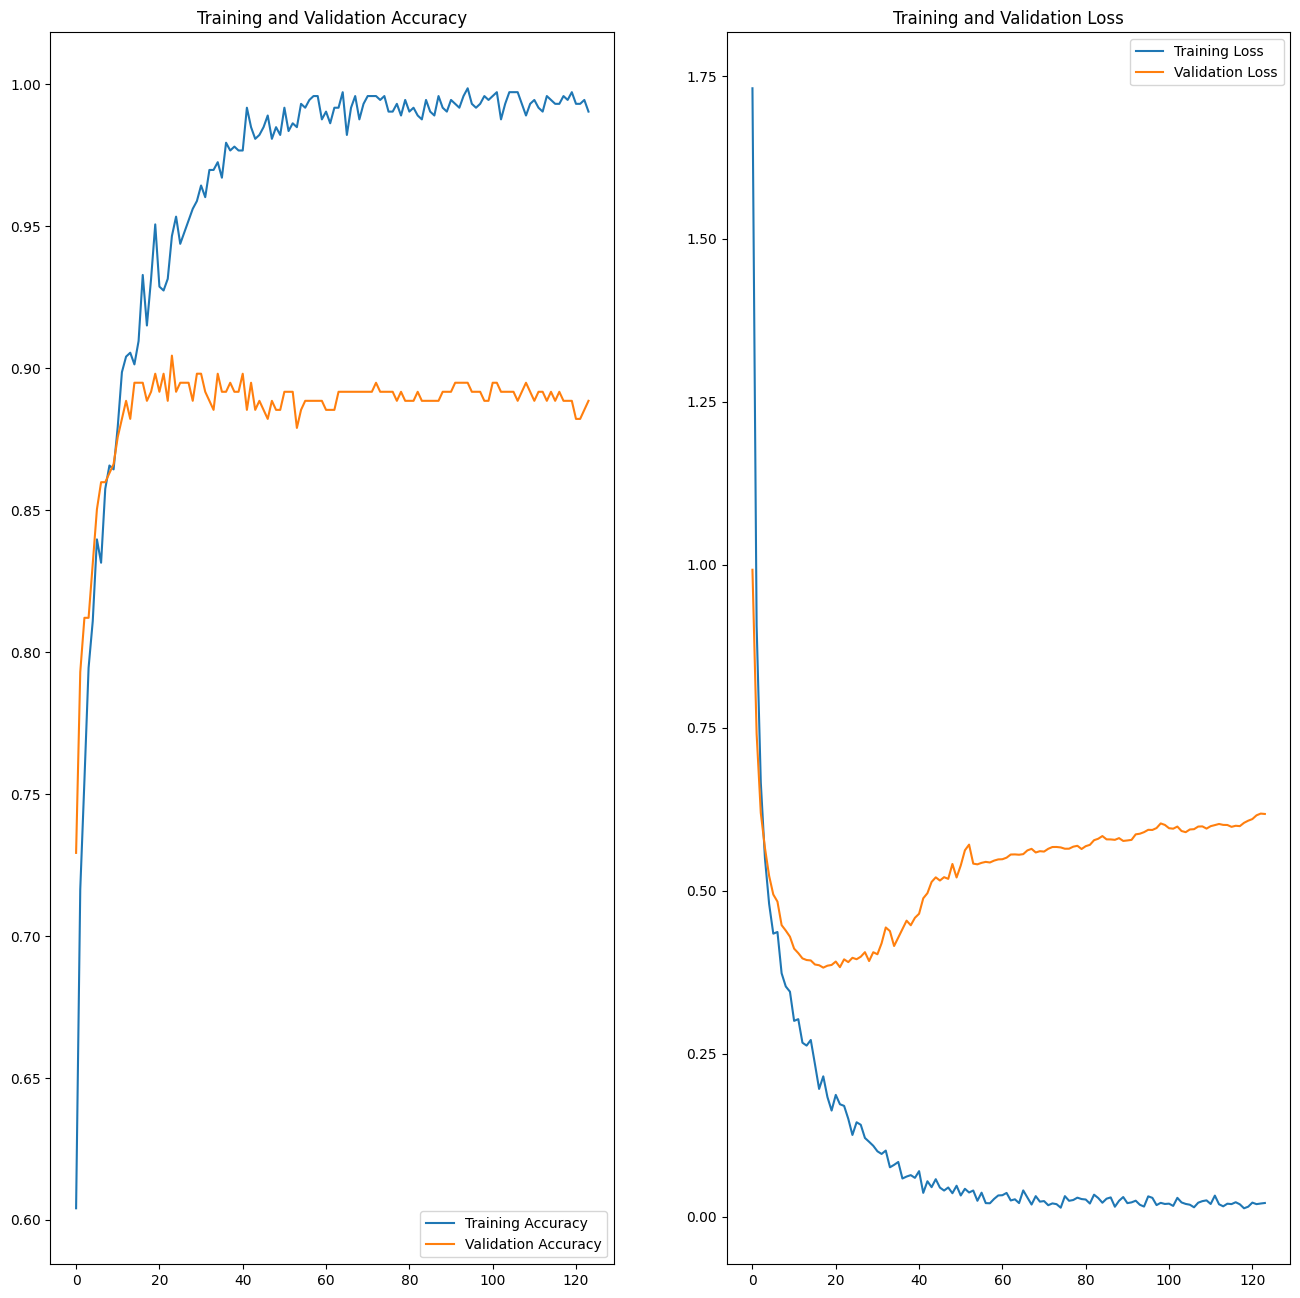

In [11]:
n_epochs = len(history.history['loss'])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(n_epochs) #change it based on epoch needed to finish building the model

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


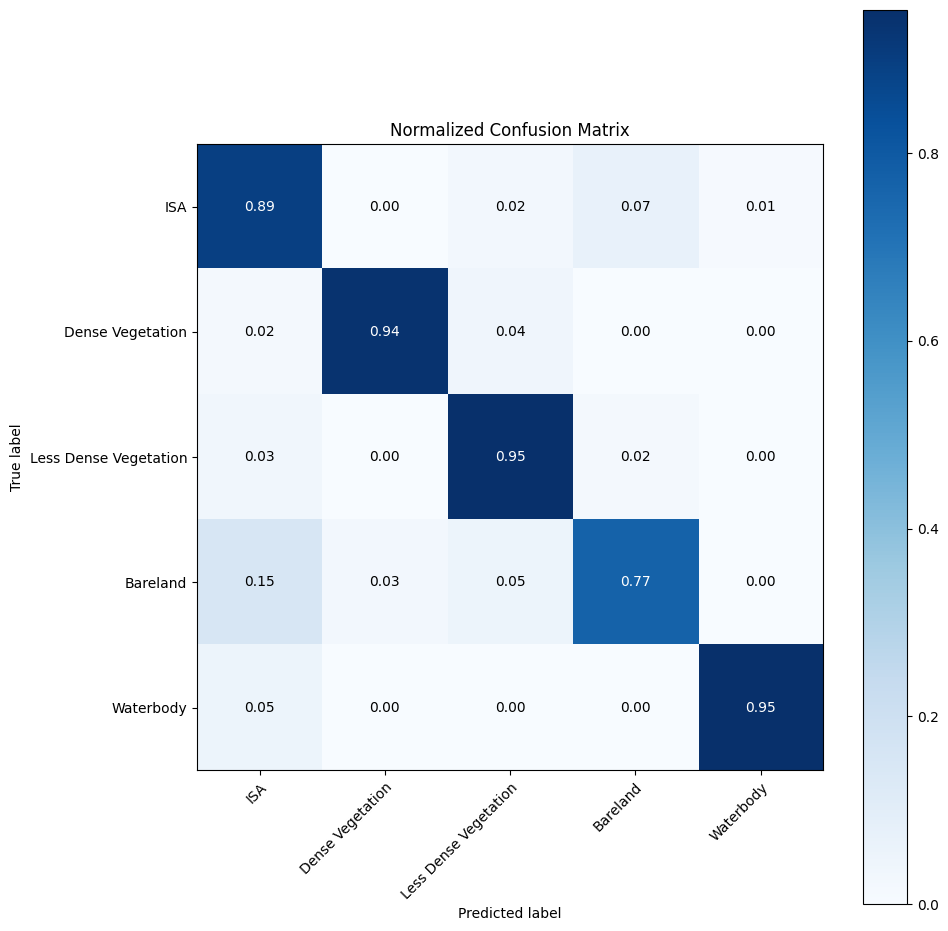

In [12]:
#confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

classes = ['ISA','Dense Vegetation','Less Dense Vegetation', 'Bareland', 'Waterbody']

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

dl_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(dl_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(dl_cm.shape[1]),
        yticks=np.arange(dl_cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title='Normalized Confusion Matrix',
        ylabel='True label',
        xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

fmt = '.2f'
thresh = dl_cm.max() / 2.
for i in range(dl_cm.shape[0]):
    for j in range(dl_cm.shape[1]):
        ax.text(j, i, format(dl_cm[i, j], fmt),
                ha="center", va="center",
                color="white" if dl_cm[i, j] > thresh else "black")
fig.tight_layout()

In [13]:
# def permutation_importance_predict(model, X_test, y_test, feature_names, n_repeats=5):
#     X_test = np.array(X_test, dtype=np.float32)
    
#     # Debug: Check shapes
#     print(f"X_test shape: {X_test.shape}")
#     print(f"y_test shape: {y_test.shape}")
    
#     # Get baseline predictions
#     baseline_pred = model.predict(X_test, verbose=0)
#     print(f"baseline_pred shape: {baseline_pred.shape}")
    
#     # Handle different y_test formats
#     if len(y_test.shape) == 1:
#         # If y_test is 1D (class indices), use it directly
#         y_true_classes = y_test
#     else:
#         # If y_test is one-hot encoded, convert to class indices
#         y_true_classes = np.argmax(y_test, axis=1)
    
#     # Convert predictions to class indices
#     baseline_pred_classes = np.argmax(baseline_pred, axis=1)
    
#     baseline_acc = np.mean(baseline_pred_classes == y_true_classes)
#     print(f"Baseline accuracy: {baseline_acc:.4f}")
    
#     importance_scores = {}
    
#     for i, feature_name in enumerate(feature_names):
#         print(f"Computing importance for {feature_name}...")
        
#         scores = []
#         for repeat in range(n_repeats):
#             X_test_perm = np.copy(X_test).astype(np.float32)
            
#             # Permute feature i across all time steps
#             for t in range(X_test.shape[1]):
#                 np.random.shuffle(X_test_perm[:, t, i])
            
#             # Use predict instead of evaluate
#             perm_pred = model.predict(X_test_perm, verbose=0)
#             perm_pred_classes = np.argmax(perm_pred, axis=1)
#             perm_acc = np.mean(perm_pred_classes == y_true_classes)
#             importance_drop = baseline_acc - perm_acc
#             scores.append(importance_drop)
        
#         importance_scores[feature_name] = {
#             'mean': np.mean(scores),
#             'std': np.std(scores),
#             'scores': scores
#         }
        
#         print(f"{feature_name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    
#     return importance_scores

In [14]:
# def plot_feature_importance(importance_scores):
#     import matplotlib.pyplot as plt
    
#     features = list(importance_scores.keys())
#     means = [importance_scores[f]['mean'] for f in features]
#     stds = [importance_scores[f]['std'] for f in features]
    
#     plt.figure(figsize=(10, 6))
#     bars = plt.bar(features, means, yerr=stds, capsize=5, alpha=0.7)
#     plt.ylabel('Importance Score (Accuracy Drop)')
#     plt.title('Feature Importance (Permutation-based)')
#     plt.xticks(rotation=0)
    
#     # Add value labels on bars
#     for bar, mean in zip(bars, means):
#         plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
#                 f'{mean:.3f}', ha='center', va='bottom')

#     plt.margins(x=0.01)
#     plt.tight_layout()
#     plt.show()

In [15]:
# feature_names = ['NDVI', 'MNDWI', 'NDBI', 'NDBSI', 'CBI', 'UCI']
# importance_results = permutation_importance_predict(model, X_test, y_test, feature_names, n_repeats=5)

# plot_feature_importance(importance_results)
# sorted_features = sorted(importance_results.items(), key=lambda x: x[1]['mean'], reverse=True)
# print("\nFeature Importance Ranking:")
# for i, (feature, scores) in enumerate(sorted_features, 1):
#     print(f"{i}. {feature}: {scores['mean']:.4f} ± {scores['std']:.4f}")